# Italy Crime Index web scraped in Python
Data scraped from [Il Sole 24 ORE](https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php) with `BeautifulSoup` library and visualized with `Matplotlib` library (inspired by [Pratap Vardhan](https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41)).

### Import the dependent libraries

In [0]:
import collections

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler

## Data

Scrape all the tables from [Il Sole 24 ORE](https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php) with `BeautifulSoup`, store them in a dictionary to create finally a `pandas` DataFrame with every city as *index* and different table names as *columns*.

In [2]:
url = "https://lab24.ilsole24ore.com/indice-della-criminalita/indexT.php"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, features="html.parser")
# Find all the tables in the HTML
tables = soup.find_all("div", attrs={"class": "grid-item"})

# Initialize a dictionary that will store all the tables
dict_table = collections.defaultdict(dict)
# Get all the headings of tables
headings = []
for tab in tables:
    t_head = tab.find("h2").text.strip()
    headings.append(t_head)
    # Get all the rows of table
    rows = tab.tbody.find_all("tr")
    for row in rows:
        cols = row.find_all("td")
        cols = [x.text.strip() for x in cols][0:4]
        if len(cols) == 4:  # because it is possible that cols is an empty list
            dict_table[t_head][cols[1]] = float(
                cols[3].replace(".", "").replace(",", ".")
            )

dict_table = dict(dict_table)
df = pd.DataFrame.from_dict(dict_table)

df.head(5)

,Classifica finale,Omicidi volontari consumati,Infanticidi,Tentati omicidi,Furti con strappo,Furti con destrezza,Furti in abitazione,Furti in esercizi commerciali,Furti di autovetture,Rapine,Estorsioni,Usura,Associazione per delinquere,Associazione di tipo mafioso,Reciclaggio e impiego di denaro,Truffe e frodi informatiche,Incendi,Stupefacenti,Violenze sessuali
Milano,7017.3,0.4,0.1,1.8,63.2,895.2,430.5,311.1,277.9,101.2,26.1,0.3,1.0,0.0,2.1,523.0,5.5,85.7,14.8
Rimini,6430.1,0.3,0.0,0.6,56.0,764.9,414.1,264.6,59.3,80.2,25.7,0.6,0.0,0.0,2.7,303.8,5.0,88.2,16.2
Firenze,6252.8,0.8,0.0,1.3,37.6,817.3,609.1,307.2,70.1,68.6,14.9,0.1,1.1,0.0,22.0,293.1,7.2,101.2,14.4
Bologna,6233.7,0.4,0.0,1.4,36.5,801.1,536.9,288.9,71.5,67.8,19.5,0.1,0.8,0.0,1.4,411.9,5.1,77.4,14.9
Torino,5339.3,0.4,0.0,1.9,55.7,515.9,419.3,187.6,199.3,79.6,17.0,0.3,0.5,0.0,1.6,418.5,5.0,85.9,9.5


Then create a new column `'Altro'` made by the difference from `'Classifica finale'` and all the other columns, and finally see the *mean* values for every columns in descending order to understand which variables have the most impact in the overall ranking.

In [3]:
df.insert(1, "Altro", df.loc[:, headings[0]] - df.loc[:, headings[1:]].sum(axis=1))
df.mean().round(1).sort_values(ascending=False)

Classifica finale                  3434.4
Altro                              2305.1
Furti in abitazione                 308.1
Truffe e frodi informatiche         296.3
Furti con destrezza                 159.8
Furti in esercizi commerciali       120.8
Furti di autovetture                101.7
Stupefacenti                         60.6
Rapine                               30.2
Estorsioni                           15.2
Furti con strappo                    14.3
Incendi                               8.9
Violenze sessuali                     7.5
Reciclaggio e impiego di denaro       2.6
Tentati omicidi                       1.7
Associazione per delinquere           0.7
Omicidi volontari consumati           0.6
Usura                                 0.2
Associazione di tipo mafioso          0.1
Infanticidi                           0.0
dtype: float64

It will be interesting to see the final ranking with all the variables scaled to have the same weight and also scaled only the 18 columns that are the most important crimes. Let's do this by creating a new `pandas` DataFrame and scaling the values with `StandardScaler()` from `scikit-learn` library.

In [4]:
scaler = StandardScaler()
df_scale = df.iloc[:, 1:].copy()

# scale all the values
df_scale[df_scale.columns] = scaler.fit_transform(
    df_scale[df_scale.columns]
)

# insert the ranking calculated by this new values
df_scale.insert(0, headings[0], df_scale.sum(axis=1))
df_scale = df_scale.rename(
    columns={"Classifica finale": "Classifica finale scaled"}
)

# insert the ranking calculated only by the selected 18 columns
df_scale.insert(
    1,
    "Classifica finale scaled No Altro",
    df_scale.loc[:, headings[1:]].sum(axis=1),
)

df_scale.head(5)


,Classifica finale scaled,Classifica finale scaled No Altro,Altro,Omicidi volontari consumati,Infanticidi,Tentati omicidi,Furti con strappo,Furti con destrezza,Furti in abitazione,Furti in esercizi commerciali,Furti di autovetture,Rapine,Estorsioni,Usura,Associazione per delinquere,Associazione di tipo mafioso,Reciclaggio e impiego di denaro,Truffe e frodi informatiche,Incendi,Stupefacenti,Violenze sessuali
Milano,31.736624,28.481694,3.254930,-0.259064,4.096419,0.117683,3.538668,4.187858,0.940008,3.150395,1.342416,3.189015,2.063758,0.178892,0.364209,-0.370812,-0.160197,2.994508,-0.451353,1.132419,2.426870
Rimini,19.057745,15.686465,3.371279,-0.396368,-0.160644,-0.867141,3.018150,3.445887,0.814047,2.380654,-0.323425,2.245873,1.987899,1.143091,-0.990394,-0.370812,0.039970,0.098623,-0.518136,1.245023,2.894169
Firenze,24.700957,22.090653,2.610305,0.290152,-0.160644,-0.292660,1.687935,3.744270,2.311760,3.085836,-0.241124,1.724899,-0.060294,-0.463907,0.499670,-0.370812,6.478677,-0.042737,-0.224290,1.830567,2.293356
Bologna,17.175449,14.546495,2.628954,-0.259064,-0.160644,-0.210591,1.608411,3.652022,1.757222,2.782906,-0.230455,1.688970,0.812085,-0.463907,0.093289,-0.370812,-0.393725,1.526749,-0.504779,0.758572,2.460248
Torino,13.837924,12.127883,1.710041,-0.259064,-0.160644,0.199752,2.996461,2.027998,0.853986,1.106029,0.743444,2.218926,0.337966,0.178892,-0.313092,-0.370812,-0.327002,1.613942,-0.518136,1.141427,0.657809


To better understand the location of every city we need to add a new label based on geographical area division [NUTS 1](https://it.m.wikipedia.org/wiki/Nomenclatura_delle_unit%C3%A0_territoriali_per_le_statistiche_dell%27Italia) created by [Eurostat](https://it.m.wikipedia.org/wiki/Eurostat). So we loaded a file `nuts_italy.csv` stored on [GitHub](https://gist.githubusercontent.com/giampaolocasolla/85a35332168c217d4068a6638bb9a7d9/raw/a2b0d1b5d3b528e0b8b7c89e886b17e6bca36983/nuts_italy.csv) created by [this site](https://wikitable2csv.ggor.de/) to get a dictionary with every cities linked to their NUTS 1.

For this project we only need 2 columns to work with `'NUTS 1', 'NUTS 3'`.

In [0]:
url_nuts = 'https://gist.githubusercontent.com/giampaolocasolla/85a35332168c217d4068a6638bb9a7d9/raw/a2b0d1b5d3b528e0b8b7c89e886b17e6bca36983/nuts_italy.csv'
dict_nuts = pd.read_csv(url_nuts).set_index("NUTS 3")["NUTS 1"].to_dict()

## Plots, colors, labels

Now we create a function to generate a specific DataFrame for future plots.

The DataFrame need all the necessary labels and only the *Top 10* and *Last 10* elements.

In [0]:
def create_df_plot(df, col, dict_nuts, numb=10):
  # select the Top 10 elements and the Last 10 elements from the original DataFrame
    df_plot_1 = (
        df.loc[:, col]
        .sort_values(ascending=False)
        .iloc[np.arange(numb).tolist() + np.arange(len(df) - numb, len(df)).tolist()]
        .copy()
        .to_frame()
    )
    df_plot_1.reset_index(level=0, inplace=True)
    df_plot_1 = df_plot_1.rename(columns={"index": "name"})
    # add a new column with NUTS values from the dictionary created early
    df_plot_1["nuts"] = df_plot_1["name"].map(dict_nuts)
    # flip values from top to bottom
    df_plot_1 = df_plot_1[::-1]
    # add a new column with labels
    df_plot_1["rank"] = [col] * (numb*2)
    df_plot_1 = df_plot_1.rename(columns={col: "value"})
    return df_plot_1

Generate a single DataFrame `df_plot` that is created from the function `create_df_plot()` above, cycled 3 times for every different ranking.

In [7]:
appended_data = []
for d, c in zip(
    [df, df_scale, df_scale],
    [
        "Classifica finale",
        "Classifica finale scaled",
        "Classifica finale scaled No Altro",
    ],
):
    data = create_df_plot(d, c, dict_nuts)
    # store DataFrame in list
    appended_data.append(data)
# merge all the stored DataFrames
df_plot = pd.concat(appended_data)

df_plot.head(5)

,name,value,nuts,rank
19,Oristano,1493.3,Isole,Classifica finale
18,Pordenone,2125.9,Nord-Est,Classifica finale
17,Benevento,2138.5,Sud,Classifica finale
16,Potenza,2216.1,Sud,Classifica finale
15,Sondrio,2239.7,Nord-Ovest,Classifica finale


We'll use `colors` to add color to the bars.

In [0]:
colors = dict(
    zip(
        ["Nord-Ovest", "Nord-Est", "Centro", "Sud", "Isole"],
        ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#aafbff"],
    )
)

Create a function `draw_barchart()` to generate a single horizontal bar plot, styling the following items:

- Text: font sizes, color, orientation, position based on values
- Format: comma separated values and axes tickers
- Axis: Move to top, color, add subtitle
- Grid: Add lines behind bars
- Remove box frame
- Add title, credit

In [0]:
def draw_barchart(
    type_rank, group_lk, title_plot, subtitle_plot, scaled=False, dx=None
):
    dff = df_plot[df_plot["rank"] == type_rank].sort_values(by="value", ascending=True)
    ax.clear()
    ax.barh(dff["name"], dff["value"], color=[colors[group_lk[x]] for x in dff["name"]])
    if dx is None:
        dx = dff["value"].max() / 200
    for i, (value, name) in enumerate(zip(dff["value"], dff["name"])):
        # text inside bars
        if value > 0:
            ax.text(value - dx, i, name, size=14, weight=600, ha="right", va="bottom")
            ax.text(
                value - dx,
                i - 0.25,
                group_lk[name],
                size=10,
                color="#444444",
                ha="right",
                va="baseline",
            )
            if not scaled:
                ax.text(value + dx, i, f"{value:,.0f}", size=14, ha="left", va="center")
        else:
            ax.text(value + dx, i, name, size=14, weight=600, ha="left", va="bottom")
            ax.text(
                value + dx,
                i - 0.25,
                group_lk[name],
                size=10,
                color="#444444",
                ha="left",
                va="baseline",
            )
            if not scaled:
                ax.text(
                    value - dx, i, f"{value:,.0f}", size=14, ha="right", va="center"
                )
    # ... polished styles
  
    # Top 10
    ax.text(
        1,
        0.7,
        "Top 10",
        transform=ax.transAxes,
        color="#777777",
        size=35,
        ha="right",
        weight=800,
    )
    # Last 10
    ax.text(
        1,
        0.3,
        "Last 10",
        transform=ax.transAxes,
        color="#777777",
        size=35,
        ha="right",
        weight=800,
    )
    # Subtitle plot
    ax.text(0, 1.06, subtitle_plot, transform=ax.transAxes, size=12, color="#777777")
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.xaxis.set_ticks_position("top")
    ax.tick_params(axis="x", colors="#777777", labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which="major", axis="x", linestyle="-")
    ax.set_axisbelow(True)
    # Title plot
    ax.text(0, 1.12, title_plot, transform=ax.transAxes, size=24, weight=600, ha="left")
    # Author, credit
    ax.text(
        1,
        0,
        "by @giampaolocasolla; credit @pratapvardhan",
        transform=ax.transAxes,
        ha="right",
        color="#777777",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
    )
    # remove box frame
    plt.box(False)

### Figure 1

Use the function `draw_barchart()` to generate the first Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants*.

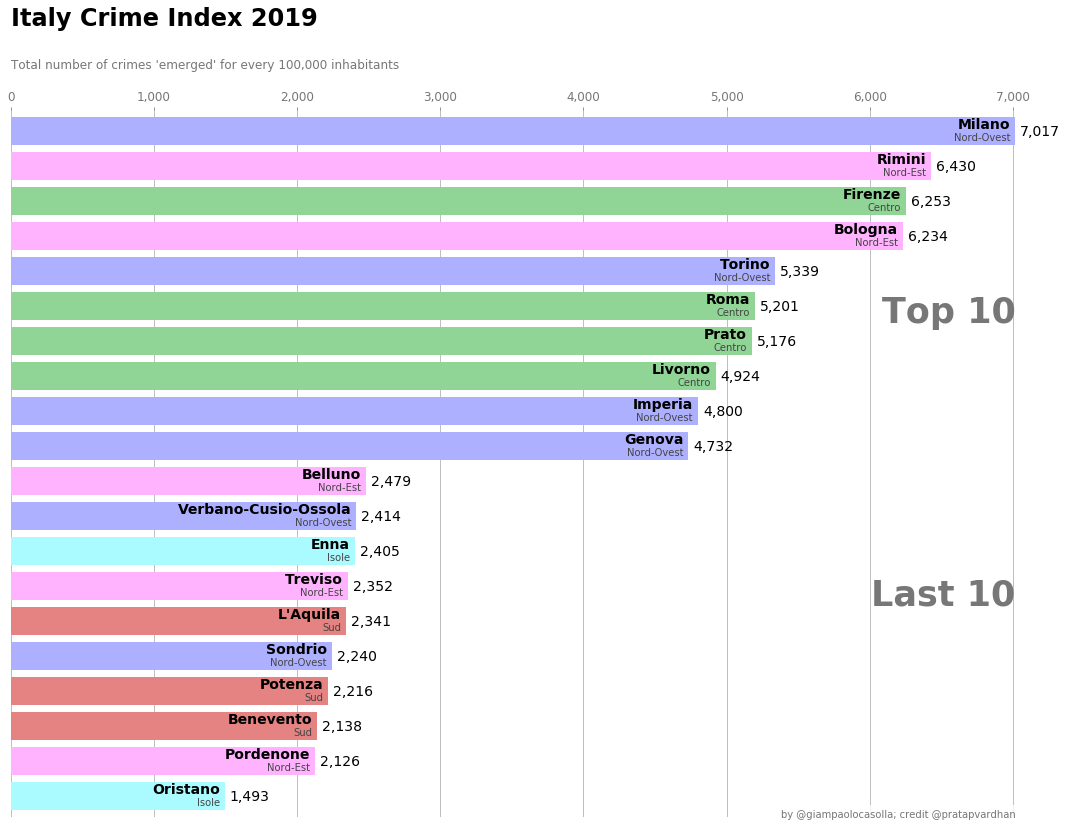

In [10]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants",
    scaled=False,
)

### Figure 2

Use the function `draw_barchart()` to generate the second Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants scaled by every types of crime*.

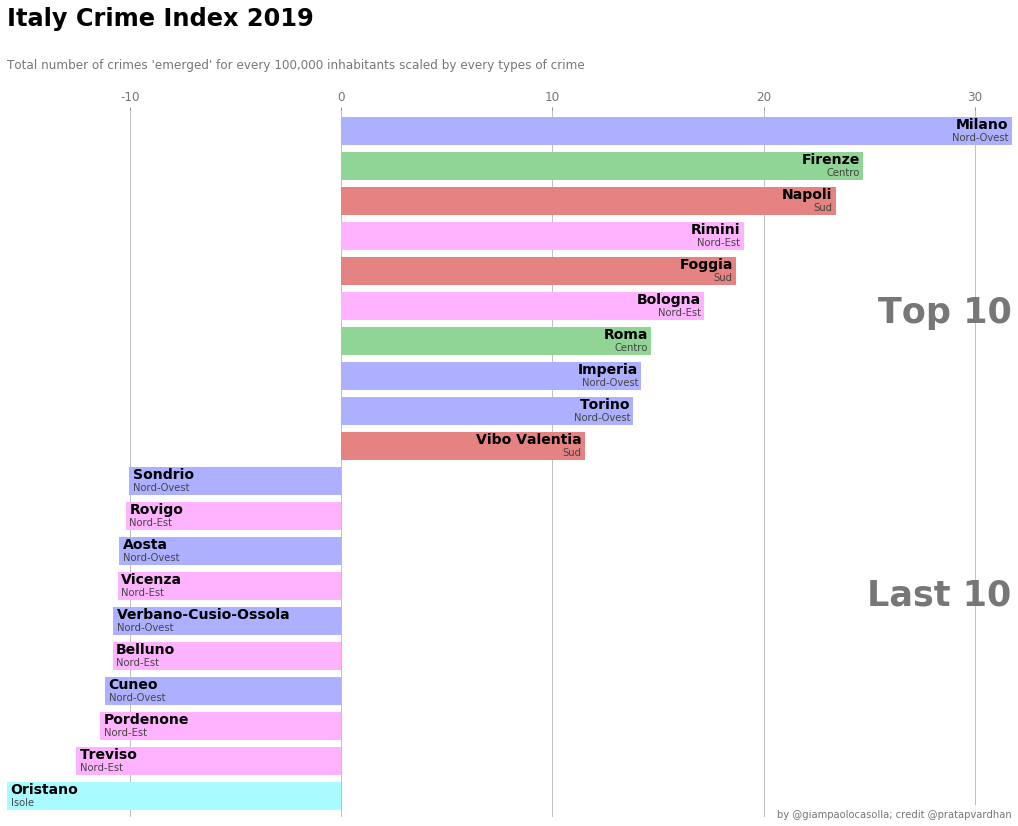

In [11]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale scaled",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants scaled by every types of crime",
    scaled=True,
)

### Figure 3

Use the function `draw_barchart()` to generate the second Figure, made by *Total number of crimes 'emerged' for every 100,000 inhabitants scaled only by selected 18 types of crime*.

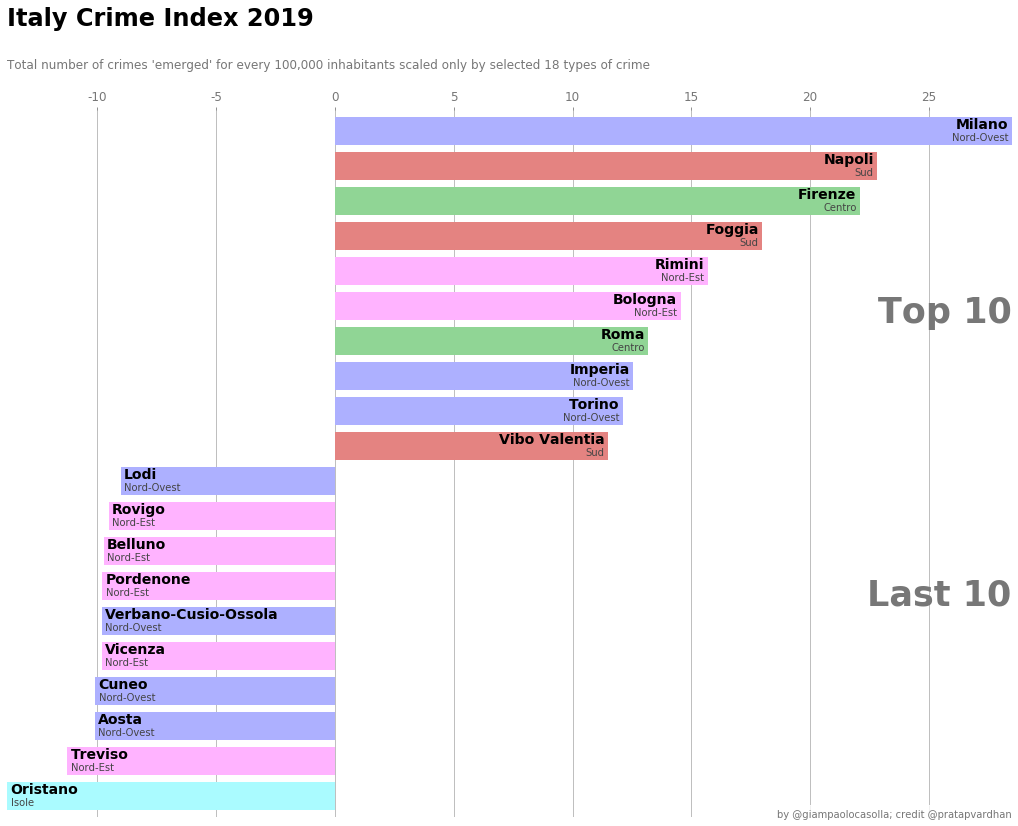

In [12]:
fig, ax = plt.subplots(figsize=(18, 13))
draw_barchart(
    "Classifica finale scaled No Altro",
    dict_nuts,
    title_plot="Italy Crime Index 2019",
    subtitle_plot="Total number of crimes 'emerged' for every 100,000 inhabitants scaled only by selected 18 types of crime",
    scaled=True,
)